In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import *
from bootstrap_func import *
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter


import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

cmap = plt.get_cmap('coolwarm', 9)
colors = cmap(np.linspace(0.1, 0.9, 9))

# Clean data loading
hairtail = pd.read_csv("./Data/cutlassfish_rmNAN.csv")

QGAGM_R3 = pd.read_csv("./Data/cutlassfish_predicts_spline3.csv")
QGAGM_R6 = pd.read_csv("./Data/cutlassfish_predicts_spline6.csv")

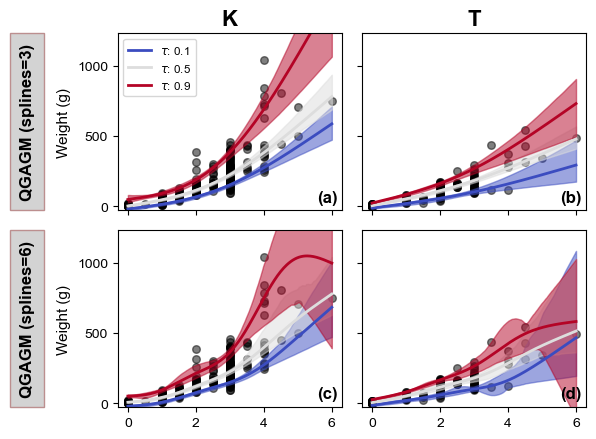

In [2]:
n_bootstrap = 10

fig, ax = plt.subplots(2, 2, figsize=(6, 4.5), sharex=True, sharey=True)

for idx_c, site in enumerate(['K', 'T']):
    idx_r = 0
    quantiles = np.linspace(0.1, 0.9, 9)
    hairtail_site = hairtail[hairtail['site'] == site]
    age_site = np.array(hairtail_site.newage)
    size_site = np.array(hairtail_site.total_w)
    age_range = np.linspace(age_site.min(), age_site.max(), 200)

    # Bootstrap QGAGM with error calculation    
    ax[idx_r, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    ax[idx_r+1, idx_c].scatter(age_site, size_site, color='k', s=30, alpha=0.5)
    site_data3 = QGAGM_R3[QGAGM_R3['site'] == site]
    site_data6 = QGAGM_R6[QGAGM_R6['site'] == site]
    for idq, q in enumerate(quantiles):
        if q in [0.1, 0.5, 0.9]:
            q_data3 = site_data3[site_data3['q'] == q]      
            ax[idx_r, idx_c].plot(q_data3['age'], q_data3['mean'], color=colors[idq], lw=2, label=r'$\tau$: '+str(q))
            ax[idx_r, idx_c].fill_between(q_data3['age'], q_data3['lower'], q_data3['upper'], color=colors[idq], alpha=0.5)
            ax[idx_r, idx_c].set_ylim(-30, 1230)
            ax[idx_r, idx_c].set_yticks([0, 500, 1000])
            if idx_c == 0:
                ax[idx_r, 0].set_title('K', fontsize=16, fontweight='bold')
                ax[idx_r, 0].legend(fontsize='small')
                ax[idx_r, 1].set_title('T', fontsize=16, fontweight='bold')
                ax[idx_r, idx_c].set_ylabel("Weight (g)", fontsize=11)
                ax[idx_r+1, idx_c].set_ylabel("Weight (g)", fontsize=11)
                

            q_data6 = site_data6[site_data6['q'] == q]      
            ax[idx_r+1, idx_c].plot(q_data6['age'], q_data6['mean'], color=colors[idq], lw=2, label='nspline=6')
            ax[idx_r+1, idx_c].fill_between(q_data6['age'], q_data6['lower'], q_data6['upper'], color=colors[idq], alpha=0.5)

# Annotations and formatting
annotations = ['QGAGM (splines=3)', 'QGAGM (splines=6)']
for i, ax_ in enumerate(ax[:, 0]):
    ax_.annotate(annotations[i], xy=(-0.4, 0.5), xycoords='axes fraction', fontsize=12, fontweight='bold',
                 rotation=90, ha='center', va='center')
    rectangle = Rectangle((-0.48, 0), 0.15, 1, transform=ax_.transAxes, facecolor="lightgray", edgecolor="rosybrown", clip_on=False)
    ax_.add_patch(rectangle)

# Add panel labels
Alphbeta = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for i, ax_ in enumerate(ax.flatten()):
    ax_.text(float(0.98), float(0.05), '('+ Alphbeta[i]+')', transform=ax_.transAxes, ha='right', fontsize=12, fontweight='bold')

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S12.pdf")
plt.savefig("./Figs/Figure_S12.png", format="png", dpi=600, bbox_inches="tight")

In [3]:
# Growth models
QGAGM_results = []
QGAGM_CPs = []  # CPs: coverage_proportions


for idx_c, site in enumerate(['K', 'T']):
    idx_r = 0
    quantiles = np.linspace(0.1, 0.9, 9)
    hairtail_site = hairtail[hairtail['site'] == site]
    age_site = np.array(hairtail_site.newage)
    size_site = np.array(hairtail_site.total_w)
    age_range = np.linspace(age_site.min(), age_site.max(), 200)

    # Bootstrap QGAGM with error calculation
    spline_num = 4
    pred_qgagm, qgagm_errors, qgagm_CPs = bootstrap_qgagm(age_site, size_site, quantiles, spline_num, n_bootstrap=n_bootstrap)


    # Store bootstrap-calculated errors
    for idq, q in enumerate(quantiles):     
        QGAGM_results.append({
            'sites': site, 'q': q,
            'mse': np.mean(qgagm_errors[q]['mse']),
            'mae': np.mean(qgagm_errors[q]['mae']),
            'mape': np.mean(qgagm_errors[q]['mape'])})

    # Store bootstrap-calculated CPs
    QGAGM_CPs.append({'sites': site, 'CPs': np.mean(qgagm_CPs)})

In [4]:
rows = []
for item in QGAGM_CPs:
    rows.append({'methods': 'Expectile QGAGM', 'sites': item['sites'], 'CPs': item['CPs']})

df = pd.DataFrame(rows)
df = df[['methods', 'sites', 'CPs']]

CPs_R = pd.read_csv("./Data/cutlassfish_CPs_spline3.csv")
coverage_means = CPs_R.groupby('site')['coverage'].mean().reset_index()
result_df = pd.DataFrame({'methods': 'QGAGM', 'sites': coverage_means['site'], 'CPs': coverage_means['coverage']})

data = pd.concat([df, result_df], ignore_index=True).sort_values(['methods'])#.reset_index(drop=True)
data

,methods,sites,CPs
0,Expectile QGAGM,K,0.604049
1,Expectile QGAGM,T,0.495270
2,QGAGM,K,0.867700
3,QGAGM,T,0.889429


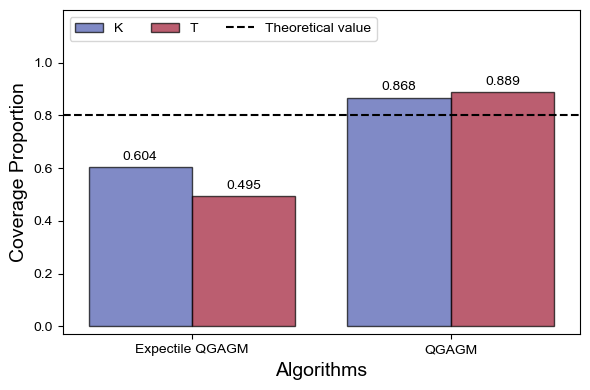

In [5]:
colors2 = {'K': colors[0], 'T': colors[8]}

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Mean absolute percentage error (MAPE) curves with bootstrap means
bar_width = 0.35
x = np.arange(len(data))  # x positions for algorithms

# Plot bar chart for each algorithms
sns.barplot(data=data, x='methods', y='CPs', hue='sites', ax=ax,
            palette=colors2, alpha=0.7, edgecolor='black', linewidth=1)

# Add theoretical value line (0.8)
ax.axhline(y=0.8, color='k', linestyle='--', label='Theoretical value')

# Set chart titles and labels
ax.set_xlabel('Algorithms', fontsize=14)
ax.set_ylabel('Coverage Proportion', fontsize=14)
ax.set_ylim(-0.03, 1.2)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend(ncol=3, loc='upper left', fontsize=10)

# # Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

# Save figures
plt.tight_layout()
plt.savefig("./Figs/Figure_S10.pdf")
plt.savefig("./Figs/Figure_S10.png", format="png", dpi=600, bbox_inches="tight")